# Classification Experiment using Supervised ML

This notebook is meant to prepare a data file and conduct machine learning experiments using traditional supervised leraning models (random forest, decision tree, SVM, etc.).  The models will be used for binary classification.

The data file will be a CSV that is updated with a sequence group column and a label (target) column for a classification problem using machine learning models to predict the target.  The "sequence_group" column will be used to group sequences that are related to each other.  The label column will be used to indicate the target value for each sequence.  The data file will be used to train and test machine learning models to predict the target value for new sequences.

The steps outlined here will build upon one another and should be run sequentially so that the final data file will be processed using a number of different models.

I highly recommend the use of a GPU for this experiment.  The use of a GPU will greatly reduce the time it takes to train the models.

## File Preperation

The basic steps for getting a file ready for the ML expermient are:

1. Load the data file
1. Filter the columns of interest which would include the features and the target (also known as the label)
1. Normalize the data
1. Create the target column lagged by one period
1. Split the data, build, compile, train & evaluate the model

The data file has been created using NinjaTrader 8 and is a CSV file.  The rows represent renko bars.  The other features represent the indicators which were used with defaults.  

**Important**: The indicators used here are not good features for this problem because they are being used on a chart type and at a granularity that is not typical for the indicator.  The indicators are being used to demonstrate the process of preparing the data file and conducting the machine learning experiments.  The utility which was used to create the data file is the "Exporter" strategy which I authored in my NinjaTrader repository on GitHub.  I have included a sample data file in the /data directory using NQ 30 tick renko bars.

**Note**: Any indicator which is a "price" type indicator has been converted to be a percentage difference from the "close" price of the related bar. This is to make the indicator values more consistent across different instruments and time frames.

### Data File Assumptions

- The data file will be a CSV
- The data file will have a header row
- The data file will have a column that contains the target value and it must be a binary value
- The data file will be in sequential chronological order
- The data file will have a column that contains a date and time value to aide sequence grouping
- The data file is already cleansed with regard to missing values and outliers


**Steps 1 & 2: Load the Data File and Filter the Columns of Interest**
- Update the file paths
- Update the column names for the features and the target

In [1]:
# STEP 1 & 2
# Declare the input & output file paths, the columns to write and the target column
# perform the imports
import pandas as pd

file_in = '../data_prod/NQ0324_30TICK_07-16_20240203175932.csv'
file_tmp = '../tmp/NQ0324_30TICK_07-16_20240203175932.csv'
file_out = '../data_prod/NQ0324_30TICK_07-16_20240203175932.csv'
file_training = '../data_prod/NQ0324_30TICK_07-16_20240203175932.csv'
file_testing = '../data_prod/NQ0324_30TICK_07-16_20240203175932.csv'

columns_to_write = [
    'date',
    'higherclose',
    'reversal',
    'trendsequence',
    'adl',
    'adx',
    'adxr',
    'apz_lower',
    'apz_upper',
    'aroonoscillator',
    'atr',
    'bollinger_lower',
    'bollinger_middle',
    'bollinger_upper',
    'bop',
    'camarilla_r1',
    'camarilla_r2',
    'camarilla_r3',
    'camarilla_r4',
    'camarilla_s1',
    'camarilla_s2',
    'camarilla_s3',
    'camarilla_s4',
    'cci',
    'chaikinmoneyflow',
    'chaikinoscillator',
    'chaikinvolatility',
    'choppinessindex',
    'cmo',
    'currentday_open',
    'currentday_low',
    'currentday_high',
    'disparityindex',
    'dm_diplus',
    'dm_diminus',
    'dmi',
    'dmindex',
    'donchian_lower',
    'donchian_mean',
    'donchian_upper',
    'doublestochastics_k',
    'easeofmovement',
    'fibonacci_pp',
    'fibonacci_r1',
    'fibonacci_r2',
    'fibonacci_r3',
    'fibonacci_s1',
    'fibonacci_s2',
    'fibonacci_s3',
    'fisherstransform',
    'fosc',
    'kama',
    'keltner_lower',
    'keltner_mean',
    'keltner_upper',
    'linreg',
    'linregintercept',
    'linregslope',
    'macd',
    'macd_avg',
    'macd_diff',
    'mama_default',
    'mama_kama',
    'mfi',
    'momentum',
    'moneyflowoscillator',
    'orderflowcumulativedelta_deltaopen',
    'orderflowcumulativedelta_deltaclose',
    'orderflowcumulativedelta_deltahigh',
    'orderflowcumulativedelta_deltalow',
    'orderflowvwap_vwap',
    'orderflowvwap_s1_lower',
    'orderflowvwap_s1_higher',
    'orderflowvwap_s2_lower',
    'orderflowvwap_s2_higher',
    'orderflowvwap_s3_lower',
    'orderflowvwap_s3_higher',
    'parabolic_sar',
    'pfe',
    'ppo',
    'priceoscillator',
    'psychologicalline',
    'rsquared',
    'relativevigorindex',
    'rind',
    'roc',
    'rsi',
    'rsi_avg',
    'rss',
    'rvi',
    'stddev',
    'stochrsi',
    'stochastics_d',
    'stochastics_k',
    'stochasticsfast_d',
    'stochasticsfast_k',
    'trix',
    'trix_signal',
    'tsf',
    'tsi',
    'ultimateoscillator',
    'vortex_viplus',
    'vortex_viminus',
    'volma',
    'volume_oscillator',
    'vroc',
    'williamsr',
    'wisemanawesomeoscillator',
    'woodiescci',
    'woodiescci_turbo',
    'woodiespivot_pp',
    'woodiespivot_r1',
    'woodiespivot_r2',
    'woodiespivot_s1',
    'woodiespivot_s2'
    ]

group_helper = 'date' # This is the column that will be used to group the data and must be a datetime column in the format '%Y-%m-%d %H:%M:%S.%f'
target_column = 'higherclose' # This is the column that will be used as the target column for the model and must be a binary column

# Load the data from the input CSV file into a pandas dataframe
df = pd.read_csv(file_in)

# Convert 'date' column to datetime format for easier manipulation
df[group_helper] = pd.to_datetime(df[group_helper], format='%Y-%m-%d %H:%M:%S.%f')

# Save the modified dataframe with only the specified columns to a new CSV file
#df.to_csv(file_tmp, index=False, columns=columns_to_write)
df[target_column] = df[target_column].astype(int)
df_filtered = df[columns_to_write]
#df_filtered.to_csv(file_tmp, index=False)

/tmp/ipykernel_19992/1448950857.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Step 3: Normalize the Data**

This step will use the MinMaxScaler to normalize the data.  The MinMaxScaler will scale the data to a range of 0 to 1.

In [2]:
from sklearn.preprocessing import RobustScaler

# List of features to exclude from normalization
features_to_exclude = [group_helper, target_column]

# Dynamically select features to normalize (all features except the ones to exclude)
features_to_normalize = [col for col in df_filtered.columns if col not in features_to_exclude]

# Initialize the Scaler
scaler = RobustScaler() # AKA Z-score normalization, better at handling outliers

# Fit the scaler to the data (for the features to be normalized)
scaler.fit(df_filtered[features_to_normalize])

# Transform the data using the fitted scaler
df_normalized = df_filtered.copy()  # Create a copy of the DataFrame to keep the original data intact
df_normalized[features_to_normalize] = scaler.transform(df_filtered[features_to_normalize])

#df_normalized.to_csv(file_out, index=False)

**Step 4: Create the Target Column Lagged by One Period**

This step will use the shift function to look ahead at the target_column to pull the value from the future onto the prior record.  This will be the "future_target_column" of interest for predictions.  Unlike RNN models, traditional ML models require the data to be in a tabular format.  This means that the data must be in a table with rows and columns (2D).

In [12]:
# STEP 4
from datetime import datetime

print(f"DateTime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

df_normalized[f'future_{target_column}'] = df_normalized[target_column].shift(-1).astype('Int8')

# Remove any rows with NaN values in the future target column & drop the 'date' column
df_normalized.dropna(subset=[f'future_{target_column}'], inplace=True)
df_normalized = df_normalized.drop(columns=['date'])

# Write the final DataFrame to a new CSV file
print(f"Record Count: {len(df_normalized)}")
#df_normalized.to_csv(file_tmp, index=False)
print(f"DateTime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

DateTime: 2024-02-06 00:13:53.661
Record Count: 20745
DateTime: 2024-02-06 00:13:53.729


**Step 5: Split the Data, Build, Compile, Train & Evaluate the Model**

/home/bbecker/proj/ml-sandbox/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DateTime: 2024-02-06 00:18:34.711
Model: Logistic Regression
Accuracy: 0.6761
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2087
         1.0       0.67      0.67      0.67      2062

    accuracy                           0.68      4149
   macro avg       0.68      0.68      0.68      4149
weighted avg       0.68      0.68      0.68      4149

Confusion Matrix:
[[1418  669]
 [ 675 1387]]


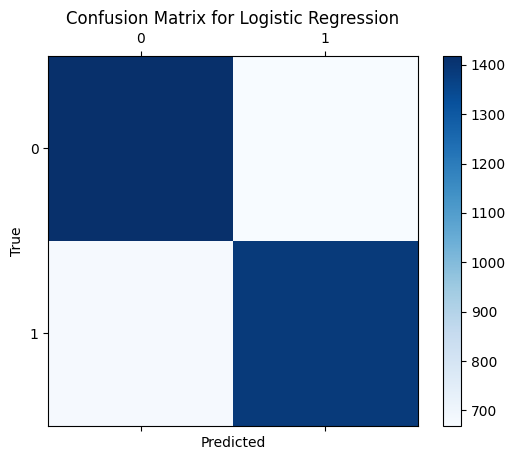

DateTime: 2024-02-06 00:18:35.516
Model: Ridge Classifier
Accuracy: 0.6756
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2087
         1.0       0.67      0.67      0.67      2062

    accuracy                           0.68      4149
   macro avg       0.68      0.68      0.68      4149
weighted avg       0.68      0.68      0.68      4149

Confusion Matrix:
[[1418  669]
 [ 677 1385]]


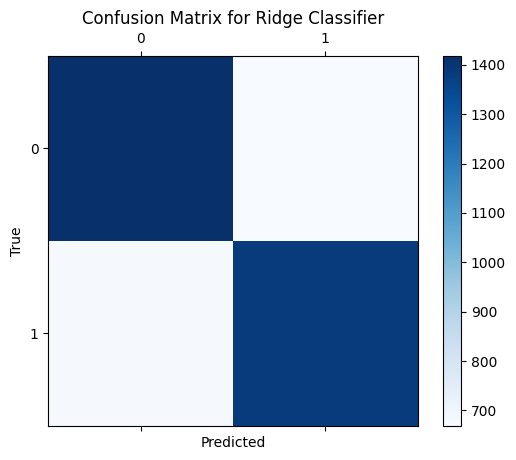

DateTime: 2024-02-06 00:19:41.191
Model: Support Vector Classification
Accuracy: 0.6761
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2087
         1.0       0.67      0.67      0.67      2062

    accuracy                           0.68      4149
   macro avg       0.68      0.68      0.68      4149
weighted avg       0.68      0.68      0.68      4149

Confusion Matrix:
[[1414  673]
 [ 671 1391]]


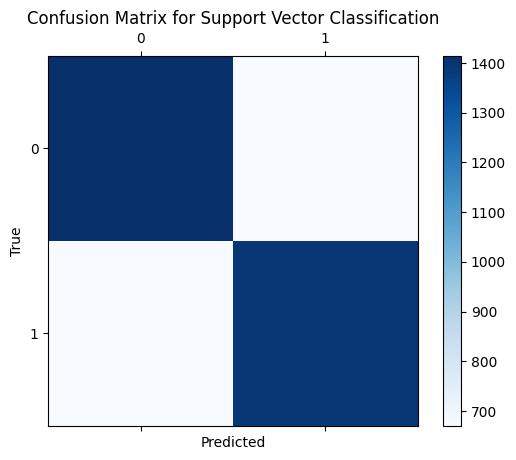

/home/bbecker/proj/ml-sandbox/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/bbecker/proj/ml-sandbox/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


DateTime: 2024-02-06 00:19:53.422
Model: Linear Support Vector Classification
Accuracy: 0.6703
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      2087
         1.0       0.67      0.67      0.67      2062

    accuracy                           0.67      4149
   macro avg       0.67      0.67      0.67      4149
weighted avg       0.67      0.67      0.67      4149

Confusion Matrix:
[[1403  684]
 [ 684 1378]]


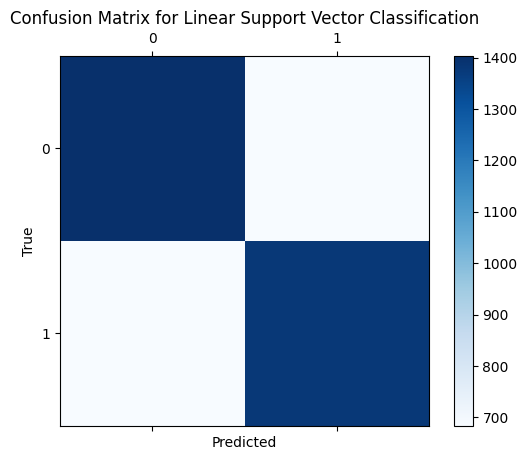

DateTime: 2024-02-06 00:19:58.596
Model: Decision Tree
Accuracy: 0.5681
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.58      0.57      2087
         1.0       0.57      0.56      0.56      2062

    accuracy                           0.57      4149
   macro avg       0.57      0.57      0.57      4149
weighted avg       0.57      0.57      0.57      4149

Confusion Matrix:
[[1212  875]
 [ 917 1145]]


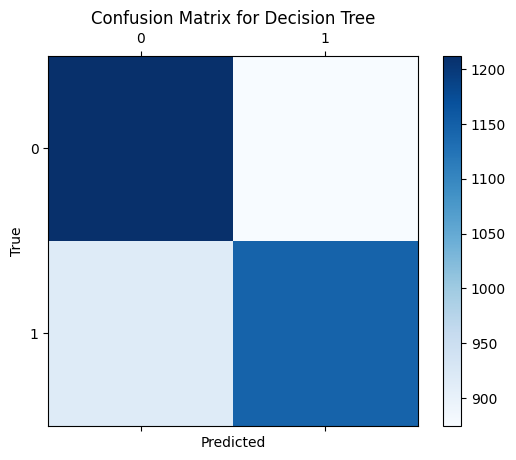

DateTime: 2024-02-06 00:20:22.792
Model: Random Forest
Accuracy: 0.6573
Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66      2087
         1.0       0.66      0.65      0.65      2062

    accuracy                           0.66      4149
   macro avg       0.66      0.66      0.66      4149
weighted avg       0.66      0.66      0.66      4149

Confusion Matrix:
[[1387  700]
 [ 722 1340]]


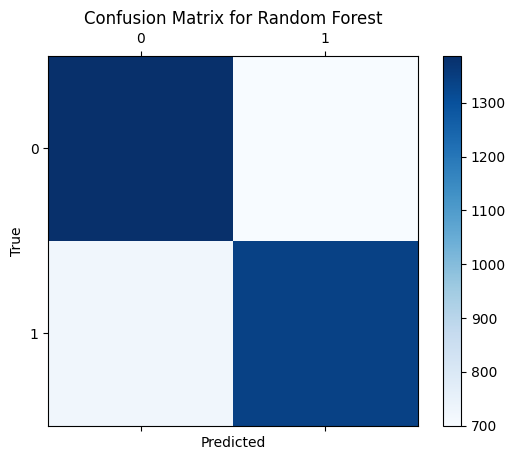

DateTime: 2024-02-06 00:20:24.226
Model: K-Neighbors Classifier
Accuracy: 0.5968
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.59      0.59      2087
         1.0       0.59      0.61      0.60      2062

    accuracy                           0.60      4149
   macro avg       0.60      0.60      0.60      4149
weighted avg       0.60      0.60      0.60      4149

Confusion Matrix:
[[1227  860]
 [ 813 1249]]


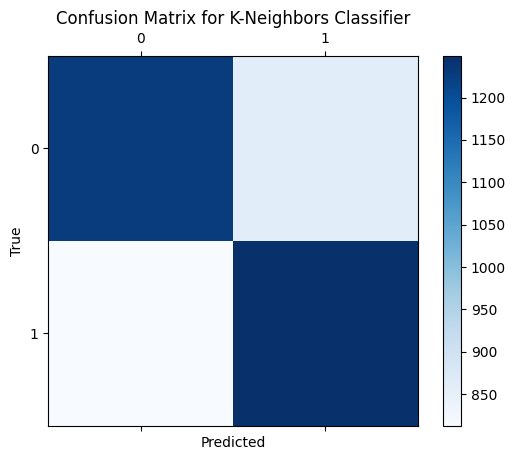

DateTime: 2024-02-06 00:20:24.899
Model: Gaussian Naive Bayes
Accuracy: 0.6062
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62      2087
         1.0       0.61      0.58      0.59      2062

    accuracy                           0.61      4149
   macro avg       0.61      0.61      0.61      4149
weighted avg       0.61      0.61      0.61      4149

Confusion Matrix:
[[1327  760]
 [ 874 1188]]


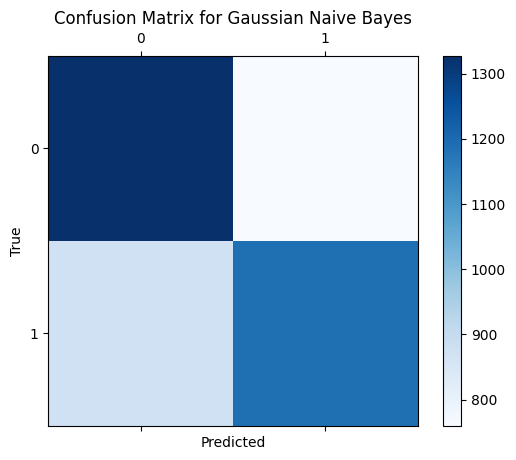

DateTime: 2024-02-06 00:20:25.425
Model: Bernoulli Naive Bayes
Accuracy: 0.5958
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60      2087
         1.0       0.59      0.59      0.59      2062

    accuracy                           0.60      4149
   macro avg       0.60      0.60      0.60      4149
weighted avg       0.60      0.60      0.60      4149

Confusion Matrix:
[[1249  838]
 [ 839 1223]]


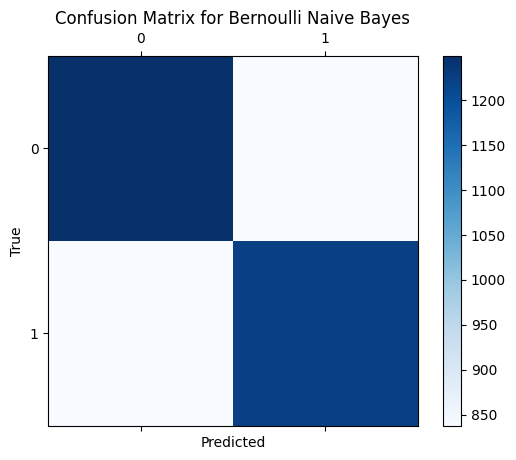

/home/bbecker/proj/ml-sandbox/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


DateTime: 2024-02-06 00:20:45.778
Model: AdaBoost Classifier
Accuracy: 0.6696
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      2087
         1.0       0.67      0.67      0.67      2062

    accuracy                           0.67      4149
   macro avg       0.67      0.67      0.67      4149
weighted avg       0.67      0.67      0.67      4149

Confusion Matrix:
[[1406  681]
 [ 690 1372]]


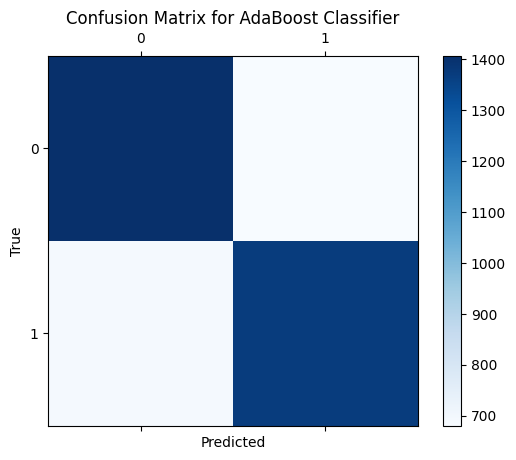

DateTime: 2024-02-06 00:21:28.141
Model: Gradient Boosting Classifier
Accuracy: 0.6746
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2087
         1.0       0.67      0.67      0.67      2062

    accuracy                           0.67      4149
   macro avg       0.67      0.67      0.67      4149
weighted avg       0.67      0.67      0.67      4149

Confusion Matrix:
[[1412  675]
 [ 675 1387]]


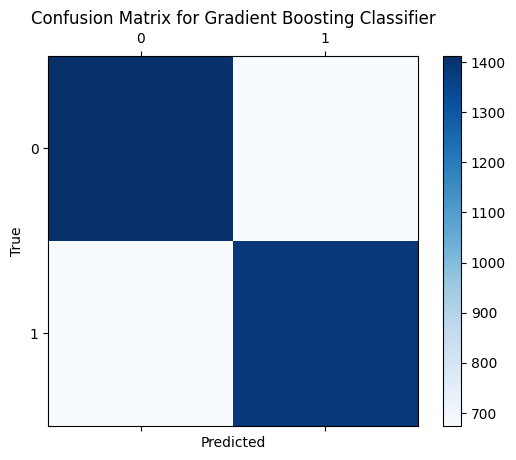

DateTime: 2024-02-06 00:21:36.615
Model: Extra Trees Classifier
Accuracy: 0.6459
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65      2087
         1.0       0.65      0.64      0.64      2062

    accuracy                           0.65      4149
   macro avg       0.65      0.65      0.65      4149
weighted avg       0.65      0.65      0.65      4149

Confusion Matrix:
[[1367  720]
 [ 749 1313]]


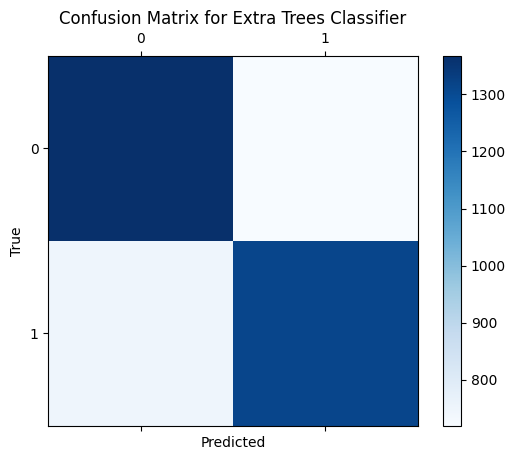

DateTime: 2024-02-06 00:26:03.402
Model: Bagging Classifier
Accuracy: 0.6541
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66      2087
         1.0       0.66      0.64      0.65      2062

    accuracy                           0.65      4149
   macro avg       0.65      0.65      0.65      4149
weighted avg       0.65      0.65      0.65      4149

Confusion Matrix:
[[1392  695]
 [ 740 1322]]


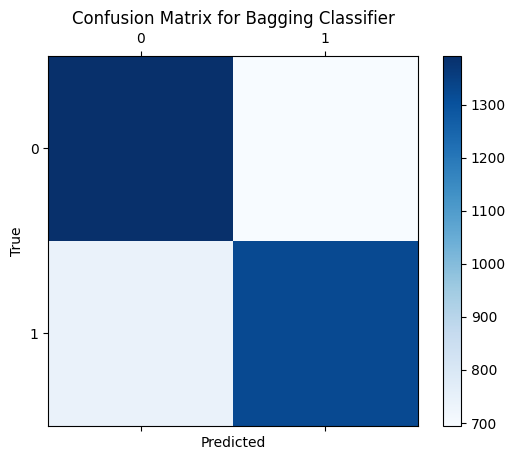

DateTime: 2024-02-06 00:26:04.550
Model: SGD Classifier
Accuracy: 0.6163
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63      2087
         1.0       0.62      0.58      0.60      2062

    accuracy                           0.62      4149
   macro avg       0.62      0.62      0.62      4149
weighted avg       0.62      0.62      0.62      4149

Confusion Matrix:
[[1363  724]
 [ 868 1194]]


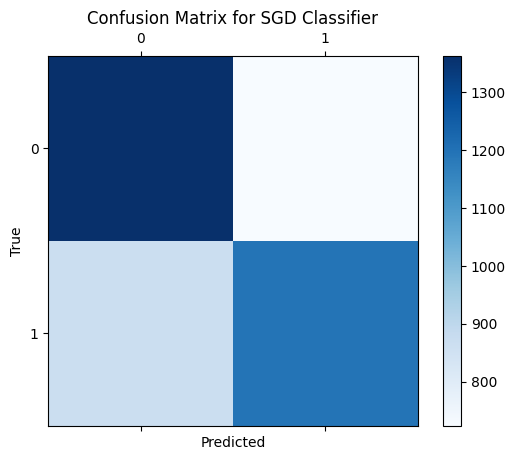

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
#import xgboost as xgb
#import lightgbm as lgb
#import catboost as cb
import matplotlib.pyplot as plt
import numpy as np

future_target_column = f'future_{target_column}'

# Splitting the DataFrame into features (X) and target (y)
X = df_normalized.drop(columns=[future_target_column])  # Features
y = df_normalized[future_target_column]  # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    ('Logistic Regression', LogisticRegression(max_iter=200)),
    ('Ridge Classifier', RidgeClassifier()),
    ('Support Vector Classification', SVC()),
    ('Linear Support Vector Classification', LinearSVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators=100)),
    ('K-Neighbors Classifier', KNeighborsClassifier()),
    ('Gaussian Naive Bayes', GaussianNB()),
    #('Multinomial Naive Bayes', MultinomialNB()),
    ('Bernoulli Naive Bayes', BernoulliNB()),
    ('AdaBoost Classifier', AdaBoostClassifier(n_estimators=100)),
    ('Gradient Boosting Classifier', GradientBoostingClassifier(n_estimators=100)),
    ('Extra Trees Classifier', ExtraTreesClassifier(n_estimators=100)),
    ('Bagging Classifier', BaggingClassifier(n_estimators=100)),
    ('SGD Classifier', SGDClassifier(max_iter=1000, tol=1e-3))
    #('XGBoost Classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    #('LightGBM Classifier', LGBMClassifier()),
    #('CatBoost Classifier', CatBoostClassifier(verbose=0))  # verbose=0 to keep the output clean
]


# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    for name, model in models:
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on testing set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        print(f"DateTime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(conf_matrix)
        
        # Plot confusion matrix
        fig, ax = plt.subplots()
        img = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {name}')
        fig.colorbar(img)
        ax.set_xticks(np.arange(len(np.unique(y))))
        ax.set_yticks(np.arange(len(np.unique(y))))
        # Assuming y contains integers as labels. Adjust if y contains other types.
        ax.set_xticklabels(np.unique(y))
        ax.set_yticklabels(np.unique(y))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# Train and evaluate each model
train_and_evaluate(models, X_train, X_test, y_train, y_test)
